In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import binary_erosion, binary_dilation
from skimage import data

In [ ]:
image_path = '/Users/luryand/Documents/DPI/dip-2024-2/img/horse.png'

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# binary
_, binary = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)

# Inverte a imagem para que o cavalo seja branco (1) e o fundo preto (0)
binary = 1 - binary

In [23]:
# Função para visualizar resultados intermediários
def show_progress(img_original, img_thinned, iteration):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(img_original, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(img_thinned, cmap='gray')
    plt.title(f'Após {iteration} iterações')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'thinning_iteration_{iteration}.png')
    plt.close()

# Elementos estruturantes para afinamento
# Conjunto de 8 elementos estruturantes para detectar pixels que podem ser removidos
def get_thinning_se():
    # Os elementos estruturantes para thinning (Golay alphabet)
    se = []
    
    # SE 0: detecção de contorno superior
    se0 = np.array([[0, 0, 0],
                   [1, 1, 1],
                   [-1, -1, -1]])
    se.append(se0)
    
    # SE 1: detecção de contorno superior-direito
    se1 = np.array([[1, 0, 0],
                   [-1, 1, 0],
                   [-1, -1, 1]])
    se.append(se1)
    
    # SE 2: detecção de contorno direito
    se2 = np.array([[-1, 0, 1],
                   [-1, 1, 1],
                   [-1, 0, 1]])
    se.append(se2)
    
    # SE 3: detecção de contorno inferior-direito
    se3 = np.array([[-1, -1, 1],
                   [-1, 1, 0],
                   [1, 0, 0]])
    se.append(se3)
    
    # SE 4: detecção de contorno inferior
    se4 = np.array([[-1, -1, -1],
                   [1, 1, 1],
                   [0, 0, 0]])
    se.append(se4)
    
    # SE 5: detecção de contorno inferior-esquerdo
    se5 = np.array([[1, -1, -1],
                   [0, 1, -1],
                   [0, 0, 1]])
    se.append(se5)
    
    # SE 6: detecção de contorno esquerdo
    se6 = np.array([[1, 0, -1],
                   [1, 1, -1],
                   [1, 0, -1]])
    se.append(se6)
    
    # SE 7: detecção de contorno superior-esquerdo
    se7 = np.array([[0, 0, 1],
                   [0, 1, -1],
                   [1, -1, -1]])
    se.append(se7)
    
    return se

In [24]:
# Implementação do operador Hit or Miss
def custom_hit_or_miss(image, se):
    """
    Implementa o operador Hit-or-Miss usando apenas erosão
    
    Parameters:
    - image: imagem binária (0 e 1)
    - se: elemento estruturante com valores 1 (hit), -1 (miss) e 0 (don't care)
    """
    hit_se = np.zeros_like(se)
    miss_se = np.zeros_like(se)
    
    hit_se[se == 1] = 1
    miss_se[se == -1] = 1
        
    # Aplica erosão na imagem para detectar correspondências com hit e também com miss
    hit_result = binary_erosion(image, hit_se)
    miss_result = binary_erosion(1 - image, miss_se)

    # O resultado é a interseção dos resultados
    result = hit_result & miss_result
    
    return result

In [25]:
def thinning_with_hit_or_miss(image):
    skeleton = image.copy()
    
    # Elementos estruturantes
    se_list = get_thinning_se()
    
    iteration = 0
    changed = True
    
    # While até não ocorrerem mais mudanças
    while changed:
        prev_skeleton = skeleton.copy()

        for se_idx, se in enumerate(se_list):
            # Aplica o hit or miss usando a implementação personalizada
            hm_result = custom_hit_or_miss(skeleton, se)
            
            # Remove os pixels identificados pelo hit or miss
            skeleton = skeleton - hm_result
        
        # Verifica se houve mudanças
        changed = not np.array_equal(skeleton, prev_skeleton)

        iteration += 1
        
        # Mostra progresso a cada 5 iterações
        if iteration % 5 == 0:
            print(f"Iteração {iteration}")
            show_progress(binary, skeleton, iteration)
    
    print(f"Afinamento completo após {iteration} iterações")
    return skeleton * 255  # Converte de volta 0-255

In [26]:
thinned_image = thinning_with_hit_or_miss(binary)

Iteração 5
Iteração 10
Iteração 15
Iteração 20
Iteração 25
Iteração 30
Iteração 35
Afinamento completo após 38 iterações


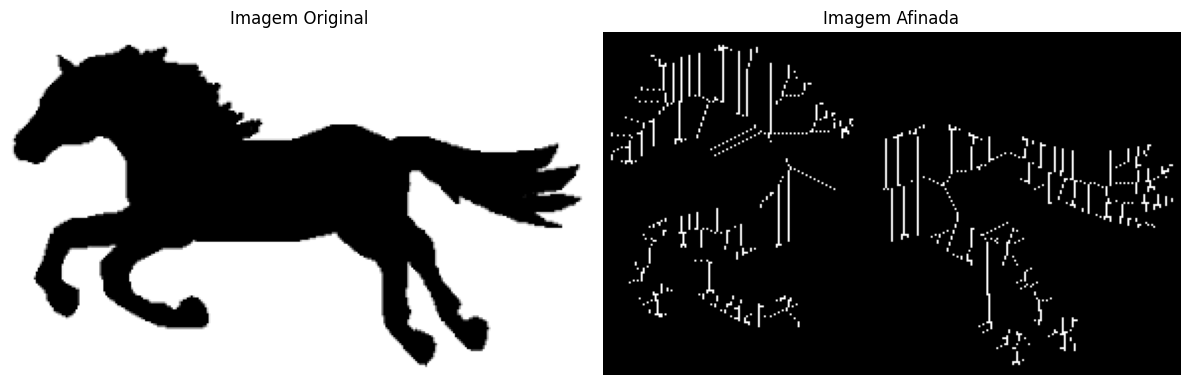

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(thinned_image, cmap='gray')
plt.title('Imagem Afinada')
plt.axis('off')

plt.tight_layout()
plt.savefig('horse_thinning_result.png')
plt.show()